# Companies bankruptcy forecast

**Autors: Iván Cortes Garrido, Alejandro Clavera Poza**

The objective of this project is to make predictions to know if a company is bankrupt, through the use of auntoencoders.

     

It will be noted that this model was applied in a simplified way because we want to explain a possible application of this type of neural network.

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Load Data Set

In [37]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
first_set = pd.read_csv('/content/drive/MyDrive/Udl/PAIA/companies-bankruptcy-forecast/bankruptcy_Train.csv')
first_set.describe()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,Attr11,Attr12,Attr13,Attr14,Attr15,Attr16,Attr17,Attr18,Attr19,Attr20,Attr21,Attr22,Attr23,Attr24,Attr25,Attr26,Attr27,Attr28,Attr29,Attr30,Attr31,Attr32,Attr33,Attr34,Attr35,Attr36,Attr37,Attr38,Attr39,Attr40,Attr41,Attr42,Attr43,Attr44,Attr45,Attr46,Attr47,Attr48,Attr49,Attr50,Attr51,Attr52,Attr53,Attr54,Attr55,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.007954,-0.007140,-0.003544,0.005005,-0.004687,0.001455,-0.006963,0.009053,0.006763,0.007456,-0.002092,-0.006495,-0.005635,-0.006965,-0.004991,0.004570,0.008561,-0.007646,-0.003973,-0.007333,0.010326,-0.004581,-0.003280,-0.011589,0.006583,0.004990,0.005052,-0.003240,0.000412,-0.007590,-0.003275,-0.006876,0.022735,0.011938,-0.004104,0.009336,0.005428,0.007472,-0.000878,-0.001987,-0.007309,-0.005063,-0.010585,-0.009997,-0.006143,0.003108,-0.004670,-0.006407,-0.000638,0.000980,-0.001850,-0.007290,-0.007953,-0.003112,-0.008807,0.009804,0.005208,-0.009751,-0.002655,0.004548,0.014331,-0.006864,0.020750,-0.003984,0.020300
std,1.396405,1.409440,1.015494,0.908020,1.394750,1.286713,1.412509,1.064426,1.171199,1.407349,1.221631,0.970984,0.625629,1.412509,1.224269,0.993429,1.057773,1.397350,1.106560,0.493696,1.397495,1.238670,1.105945,1.102610,1.360429,0.984670,1.337143,0.643955,1.005820,0.361359,1.061738,0.421354,1.180593,1.099100,1.164521,1.090159,1.287845,1.411253,0.902576,0.709378,0.004954,1.078583,0.124915,0.063287,1.411125,0.888618,0.839548,1.178670,1.024896,0.990897,1.051308,0.412149,0.328402,0.647862,0.818791,0.017370,0.718682,0.026124,0.467139,1.252571,1.171160,0.277288,1.115182,0.930875,0.141032
min,-9.474787,-140.604555,-25.597146,-0.381641,-138.720013,-26.249562,-141.176615,-0.966015,-1.294340,-2.528495,-97.172752,-77.279590,-4.252557,-141.176615,-64.255946,-7.243222,-1.010521,-139.010425,-98.844244,-0.073661,-0.020061,-100.671151,-99.021061,-89.689447,-7.493528,-7.834373,-0.184270,-2.388893,-7.035371,-0.233613,-92.355994,-0.035224,-3.442200,-2.415525,-81.571260,-1.495787,-0.035399,-0.953278,-86.746670,-3.325749,-0.366493,-91.709800,-0.032807,-0.022776,-140.725069,-2.568781,-0.070113,-88.957981,-86.866520,-0.991489,-1.560279,-0.034623,-14.895609,-2.443033,-19.007973,-1.657288,-42.381245,-0.037484,-3.218490,-0.048598,-0.412525,-0.022204,-0.743297,-0.050969,0.000000
25%,-0.079776,-0.055604,-0.516971,-0.192306,0.006798,-0.016047,-0.008018,-0.445667,-0.388184,-0.068584,-0.305785,-0.161555,-0.012186,-0.008023,-0.020505,-0.425618,-0.445706,-0.010035,0.001363,-0.050518,-0.016220,-0.334718,0.004364,-0.039500,-0.176716,-0.409379,-0.009983,-0.021091,-0.639265,-0.023100,-0.001732,-0.024332,-0.382484,-0.617246,-0.362912,-0.594583,-0.034381,-0.045302,-0.011692,-0.137306,-0.007438,-0.009199,-0.020529,-0.016182,0.003847,-0.183804,-0.035019,-0.224550,0.005939,-0.479160,-0.671175,-0.023721,-0.029205,-0.020771,-0.127228,0.009315,0.003199,-0.010766,-0.022740,-0.043418,-0.221237,-0.016847,-0.371384,-0.041603,0.000000
50%,-0.019204,0.000246,0.003186,-0.117972,0.007302,-0.016047,0.004280,-0.260150,-0.307842,0.000253,-0.051330,-0.094603,-0.011256,0.004286,-0.011942,-0.2444

We expand the data set because the original is small. This extension belongs to the test data set and is labeled by the probability that it is bankruptcy.

With this probability and a threshold value we will assign each data to one of the 2 classes.

In [39]:
LIMIT = 0.7

ampliation = pd.read_csv('/content/drive/MyDrive/Udl/PAIA/companies-bankruptcy-forecast/bankruptcy_Test_X.csv')
labels =  pd.read_csv('/content/drive/MyDrive/Udl/PAIA/companies-bankruptcy-forecast/bankruptcy_sample_Y.csv')
# Add labels to ampliation set
ampliation['class'] = labels['class']
ampliation = ampliation.drop('ID',1)

# Assing Class
ampliation.loc[ampliation['class'] >= LIMIT, 'class'] = 1
ampliation.loc[ampliation['class'] < LIMIT, 'class'] = 0

In [40]:
ampliation.describe()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,Attr11,Attr12,Attr13,Attr14,Attr15,Attr16,Attr17,Attr18,Attr19,Attr20,Attr21,Attr22,Attr23,Attr24,Attr25,Attr26,Attr27,Attr28,Attr29,Attr30,Attr31,Attr32,Attr33,Attr34,Attr35,Attr36,Attr37,Attr38,Attr39,Attr40,Attr41,Attr42,Attr43,Attr44,Attr45,Attr46,Attr47,Attr48,Attr49,Attr50,Attr51,Attr52,Attr53,Attr54,Attr55,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000
mean,-0.010541,0.006630,0.011161,0.005938,0.006390,0.002621,0.006631,-0.013657,-0.026559,-0.007115,-0.006408,0.008793,-0.001221,0.006634,0.010381,-0.016208,-0.012890,0.007350,-0.004864,-0.010535,-0.008913,0.003846,-0.005748,0.020414,-0.002471,-0.015615,-0.000563,0.018023,0.001804,-0.008583,-0.006693,-0.007280,-0.019767,-0.029204,-0.002140,-0.018118,-0.003726,-0.007269,-0.007840,0.013557,-0.006860,-0.003882,-0.007276,-0.005989,0.006478,0.006589,0.009384,0.007067,0.000699,-0.003884,-0.001980,-0.006932,0.034438,0.017867,-0.004420,0.009640,-0.014331,-0.009676,0.020127,0.007055,-0.026833,-0.009445,-0.016885,0.014959,0.20020
std,0.223307,0.098127,0.966377,1.473476,0.041395,0.812655,0.039043,0.988794,0.753446,0.123566,0.708989,1.374122,0.764130,0.039044,0.788946,0.986804,1.000057,0.212677,1.151971,0.150988,0.263486,0.675769,1.153262,1.246262,0.366114,0.998332,0.646166,1.775810,0.990566,0.359873,1.221735,0.348490,0.825435,0.867981,0.787677,0.875755,0.481585,0.069893,1.472316,1.674911,0.016221,1.197518,0.324221,0.325036,0.072485,1.495290,1.351450,0.801371,1.106378,1.083445,0.922677,0.349015,1.888252,1.773029,0.606856,0.028366,1.692235,0.028407,1.879404,0.785575,0.608720,0.089689,1.004378,1.449842,0.40019
min,-5.317246,-0.168327,-10.368352,-0.379629,-1.615588,-17.308228,-0.399457,-1.039097,-1.290710,-3.300808,-7.186611,-9.386974,-3.413834,-0.399462,-24.437538,-4.880473,-1.007070,-0.395462,-80.244699,-0.073654,-0.020058,-7.407734,-80.387534,-2.178885,-8.422142,-4.031989,-1.298104,-1.129728,-6.376193,-0.084535,-85.035597,-0.032471,-0.764647,-1.536153,-8.793214,-1.494471,-0.035848,-0.864074,-103.812799,-2.558935,-0.197629,-80.980267,-0.032819,-0.022729,-2.897988,-1.970946,-0.043882,-23.376979,-77.555121,-0.973357,-1.565038,-0.031651,-11.955267,-1.186072,-10.074867,-1.988372,-118.282903,-0.025341,-4.816178,-0.048552,-0.413029,-0.022189,-0.743297,-0.050969,0.00000
25%,-0.079152,-0.054954,-0.537622,-0.194596,0.006781,-0.016047,-0.007849,-0.442027,-0.389620,-0.066698,-0.307683,-0.160458,-0.012189,-0.007851,-0.020214,-0.425815,-0.441361,-0.009865,0.001578,-0.049869,-0.016228,-0.326174,0.004425,-0.039152,-0.166131,-0.411872,-0.009982,-0.021188,-0.634872,-0.023121,-0.001661,-0.024168,-0.383593,-0.622207,-0.361847,-0.590230,-0.034392,-0.045280,-0.011536,-0.137700,-0.007437,-0.008433,-0.020160,-0.016113,0.003850,-0.188051,-0.034842,-0.221167,0.005926,-0.475729,-0.667219,-0.023577,-0.028970,-0.020842,-0.127309,0.009317,0.003322,-0.010718,-0.022737,-0.043532,-0.222173,-0.016767,-0.375022,-0.041438,0.00000
50%,-0.020132,0.000075,-0.001219,-0.118548,0.007305,-0.016047,0.004168,-0.264747,-0.316819,-0.000748,-0.057563,-0.098004,-0.011284,0.004170,-0.011599,-0.249079,-0.260114,0.001971,0.016415,-0.028156,-0.015683,-0.058288,0.017177,-0.004619,0.027

Once the extension is adapted to the original set format, we concatenate them.

In [41]:
data_set = pd.concat((first_set, ampliation))

## Data analysis

In [42]:
data_set.describe()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,Attr11,Attr12,Attr13,Attr14,Attr15,Attr16,Attr17,Attr18,Attr19,Attr20,Attr21,Attr22,Attr23,Attr24,Attr25,Attr26,Attr27,Attr28,Attr29,Attr30,Attr31,Attr32,Attr33,Attr34,Attr35,Attr36,Attr37,Attr38,Attr39,Attr40,Attr41,Attr42,Attr43,Attr44,Attr45,Attr46,Attr47,Attr48,Attr49,Attr50,Attr51,Attr52,Attr53,Attr54,Attr55,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,0.001789,-0.002550,0.001358,0.005316,-0.000995,0.001844,-0.002432,0.001483,-0.004345,0.002599,-0.003531,-0.001399,-0.004164,-0.002432,0.000133,-0.002356,0.001410,-0.002648,-0.004270,-0.008400,0.003913,-0.001772,-0.004102,-0.000921,0.003565,-0.001878,0.003180,0.003848,0.000876,-0.007921,-0.004415,-0.007010,0.008568,-0.001776,-0.003449,0.000184,0.002376,0.002558,-0.003199,0.003194,-0.007159,-0.004669,-0.009482,-0.008661,-0.001936,0.004268,0.000015,-0.001916,-0.000192,-0.000642,-0.001894,-0.007171,0.006178,0.003881,-0.007345,0.009749,-0.001305,-0.009726,0.004939,0.005384,0.000610,-0.007724,0.008205,0.002330,0.080267
std,1.147440,1.152195,0.999382,1.128390,1.139053,1.150576,1.153528,1.039849,1.050661,1.151309,1.078158,1.121557,0.674939,1.153528,1.098496,0.991241,1.038906,1.147522,1.121863,0.412414,1.151162,1.083998,1.121901,1.152543,1.130706,0.989260,1.153730,1.152202,1.000728,0.360852,1.117579,0.398537,1.075478,1.028004,1.053958,1.023745,1.087647,1.152991,1.124973,1.127167,0.010203,1.119593,0.213166,0.194641,1.152935,1.127657,1.038579,1.067812,1.052721,1.022644,1.010222,0.392223,1.122781,1.152234,0.754769,0.021664,1.139664,0.026906,1.150139,1.118751,1.018948,0.232250,1.079624,1.130634,0.271715
min,-9.474787,-140.604555,-25.597146,-0.381641,-138.720013,-26.249562,-141.176615,-1.039097,-1.294340,-3.300808,-97.172752,-77.279590,-4.252557,-141.176615,-64.255946,-7.243222,-1.010521,-139.010425,-98.844244,-0.073661,-0.020061,-100.671151,-99.021061,-89.689447,-8.422142,-7.834373,-1.298104,-2.388893,-7.035371,-0.233613,-92.355994,-0.035224,-3.442200,-2.415525,-81.571260,-1.495787,-0.035848,-0.953278,-103.812799,-3.325749,-0.366493,-91.709800,-0.032819,-0.022776,-140.725069,-2.568781,-0.070113,-88.957981,-86.866520,-0.991489,-1.565038,-0.034623,-14.895609,-2.443033,-19.007973,-1.988372,-118.282903,-0.037484,-4.816178,-0.048598,-0.413029,-0.022204,-0.743297,-0.050969,0.000000
25%,-0.079537,-0.055321,-0.524465,-0.193214,0.006792,-0.016047,-0.007943,-0.444471,-0.388453,-0.068113,-0.306522,-0.161381,-0.012188,-0.007944,-0.020411,-0.425669,-0.444046,-0.009957,0.001449,-0.050357,-0.016223,-0.332360,0.004394,-0.039432,-0.174272,-0.410122,-0.009983,-0.021122,-0.637825,-0.023109,-0.001714,-0.024272,-0.383132,-0.619200,-0.362853,-0.593747,-0.034384,-0.045302,-0.011652,-0.137473,-0.007438,-0.008981,-0.020421,-0.016161,0.003848,-0.185113,-0.034943,-0.223826,0.005937,-0.478031,-0.670285,-0.023669,-0.029140,-0.020789,-0.127231,0.009316,0.003220,-0.010745,-0.022739,-0.043458,-0.221349,-0.016821,-0.372697,-0.041533,0.000000
50%,-0.019565,0.000188,0.002177,-0.118174,0.007303,-0.016047,0.004215,-0.261585,-0.310625,-0.000044,-0.053118,-0.095557,-0.011271,0.004220,-0.011856,-0.2457

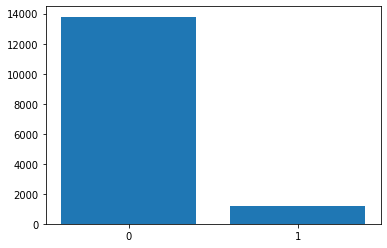

0.0    13796
1.0     1204
Name: class, dtype: int64


In [43]:
# Evaluate the number of samples for each class
classes = data_set['class'].unique()
values = data_set['class'].value_counts()
plt.bar(classes, values)
plt.xticks(classes)
plt.show()
print(values)

Can be observed in the previous graph, the data set contains a greater number of examples of companies that have not entered bankruptcy, therefore it will be the data that will be used to train the autoencoder, while the small remaining part It will be used to test that the model produces a greater error in the prediction and thus detect the anomaly.

We obtain the data of the companies that belong to class 0 that represent that they are not bankrup. On the other hand, the rest of the data will be test because they are of class 1(bankrup).

### Analysis of the diversity of the examples

In this section we will analyze the diversity of examples that the training set has, for this, the KMeans will be used to group the data according to their similarity.

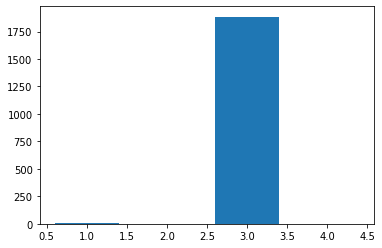

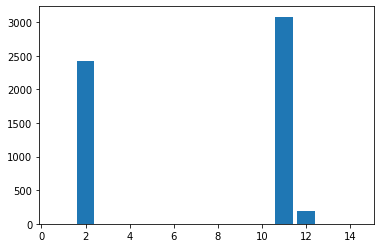

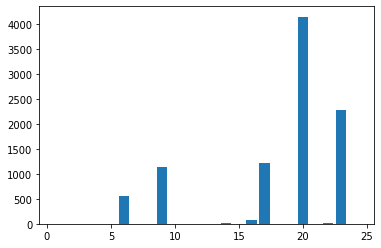

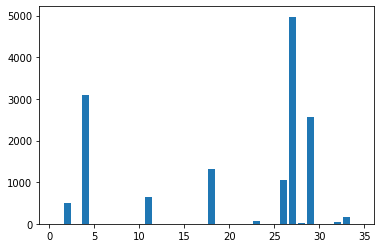

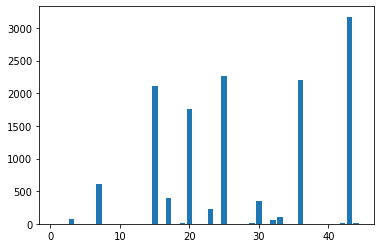

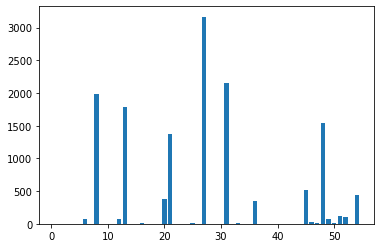

In [44]:
from sklearn.cluster import KMeans

data = data_set.drop('class', 1)
for n_clusters in range(5,60,10):
  kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(data)
  counts = {}
  for index,i in enumerate(kmeans.predict(data)):
    if i != 0:
      counts[i] = counts.get(i,0) + 1

  group = list(counts.keys())
  count_groups = list(counts.values())
  plt.figure()
  plt.bar(group, count_groups)
  plt.show()

Once the Kmeans algorithm has been applied to group the data and testing with different cluster numbers, it can be seen that there is not a great diversity of examples since many of them are similar.

## Preprocessing

The first step is to standarized the data in order to facilitate the autoencoder's task of replicating the input data.

In [45]:
# Data normalization
from sklearn import preprocessing

def normalize(data_set):
  scaler = preprocessing.StandardScaler()
  data = data_set.drop('class', 1)
  train_x = data[data_set['class'] == 0]
  test_x = data[data_set['class'] == 1]
  train_x = scaler.fit_transform(train_x)
  test_x = scaler.fit_transform(test_x)
  return train_x, test_x

train_x, test_x = normalize(data_set)
df = pd.DataFrame(train_x)
df.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63
count,1.379600e+04,1.379600e+04,1.379600e+04,1.379600e+04,1.379600e+04,1.379600e+04,1.379600e+04,1.379600e+04,1.379600e+04,1.379600e+04,1.379600e+04,1.379600e+04,1.379600e+04,1.379600e+04,1.379600e+04,1.379600e+04,1.379600e+04,1.379600e+04,1.379600e+04,1.379600e+04,1.379600e+04,1.379600e+04,1.379600e+04,1.379600e+04,1.379600e+04,1.379600e+04,1.379600e+04,1.379600e+04,1.379600e+04,1.379600e+04,1.379600e+04,1.379600e+04,1.379600e+04,1.379600e+04,1.379600e+04,1.379600e+04,1.379600e+04,1.379600e+04,1.379600e+04,1.379600e+04,1.379600e+04,1.379600e+04,1.379600e+04,1.379600e+04,1.379600e+04,1.379600e+04,1.379600e+04,1.379600e+04,1.379600e+04,1.379600e+04,1.379600e+04,1.379600e+04,1.379600e+04,1.379600e+04,1.379600e+04,1.379600e+04,1.379600e+04,1.379600e+04,1.379600e+04,1.379600e+04,1.379600e+04,1.379600e+04,1.379600e+04,1.379600e+04
mean,7.269844e-18,1.332855e-17,1.225221e-17,3.649533e-17,2.948540e-17,4.192282e-17,1.166688e-17,6.317230e-18,-1.414738e-17,3.493589e-18,-1.870624e-17,-1.609485e-19,7.299896e-18,-1.102749e-18,-1.521699e-17,1.995762e-17,1.705250e-17,7.065389e-19,-1.252657e-17,3.897972e-18,2.369464e-18,5.432013e-17,-1.821611e-17,1.985049e-17,-1.436063e-17,9.709221e-18,7.843123e-17,-3.526760e-17,9.375252e-18,2.890435e-17,3.244044e-17,2.875849e-17,2.395342e-17,-2.366748e-17,8.530273e-19,7.999142e-18,1.125483e-17,5.716188e-18,-3.957322e-18,4.617211e-19,9.767891e-17,4.696680e-18,5.302028e-18,-1.317766e-19,1.337520e-17,6.484214e-18,3.083485e-18,2.660479e-17,-9.312885e-18,-1.106974e-17,-1.135492e-17,8.721902e-18,2.884751e-18,-2.702452e-17,1.973028e-17,1.009530e-16,3.009360e-18,-9.581468e-19,9.827417e-18,8.688203e-18,1.986834e-17,2.167776e-19,8.214411e-18,3.600369e-17
std,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00
min,-7.936505e+00,-1.170624e+02,-2.556845e+01,-4.634456e-01,-1.168069e+02,-2.188545e+01,-1.173801e+02,-9.877091e-01,-1.207469e+00,-2.754415e+00,-8.805042e+01,-8.912669e+01,-6.043337e+00,-1.173801e+02,-5.812935e+01,-7.203925e+00,-9.609332e-01,-1.161837e+02,-1.043111e+02,-1.527747e-01,-2.137500e-02,-9.065226e+01,-1.045835e+02,-7.465318e+01,-7.178593e+00,-7.797886e+00,-1.569109e-01,-4.340402e+00,-7.025269e+00,-7.241453e-01,-1.014066e+02,-6.963202e-02,-3.212670e+00,-2.317186e+00,-7.621960e+01,-1.453889e+00,-3.373995e-02,-7.963494e-01,-1.127221e+02,-4.547770e+00,-3.609518e+01,-9.755328e+01,-2.027743e-01,-2.292476e-01,-1.170628e+02,-3.109658e+00,-7.008065e-02,-8.141286e+01,-9.931409e+01,-9.587090e-01,-1.530243e+00,-6.888641e-02,-2.033567e+01,-4.415185e+00,-2.478687e+01,-1.124283e+02,-6.769098e+01,-1.239137e+00,-6.556901e+00,-4.769873e-02,-3.952535e-01,-5.982900e-02,-7.398541e-01,-5.605382e-02
25%,-7.050951e-02,-4.305257e-02,-5.262764e-01,-2.358099e-01,7.042905e-03,-1.577506e-02,-4.180292e-03,-4.260319e-01,-3.595611e-01,-5.945053e-02,-2.787844e-01,-1.820333e-01,-1.271095e-02,-4.178740e-03,-1.659571e-02,-4.270843e-01,-4.253171e-01,-5.846395e-03,2.811011e-05,-9.805608e-02,-1.817341e-02,-3.012682e-01,2.892059e-03,-3.167709e-02,-1.507875e-01,-4.132845e-01,-1.201985e-02,-2.851087e

The training set is divided, to obtain a validation set that will be used to validate the training status of the model.

In [46]:
from sklearn.model_selection import train_test_split
train_x, validation_x, _, _ = train_test_split(train_x, train_x, train_size=0.85, random_state = 32)

## Model

In this section we will create and train the model using the Keras api that Tentsorflow offers us.

In [47]:
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import TensorBoard

In [48]:
# Create the model
class Autoencoder(Model):
  def __init__(self, input_shape,name=None):
    super(Autoencoder, self).__init__(name=name)
    # Genere the encoder
    self.encoder = Sequential([
        layers.InputLayer(input_shape=input_shape, name='input'),
        layers.Dense(50, activation='tanh'),
        layers.Dense(40, activation='relu')
    ], name='encoder')

    # Genere the decoder
    self.decoder = Sequential([
        layers.Dense(50, activation='relu'),
        layers.Dense(54, activation='relu'),
        layers.Dense(input_shape, activation='tanh'),
    ], name='decoder')

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

  def predict(self, x, umbral=0.1 ,decoded=False):
    prediction = super(Autoencoder, self).predict(x)
    # If decoded == True the autoencoder return returns the replica of the input data that predicts
    if decoded:
      return prediction
    # Calculate error
    errors = np.mean(np.power(x - prediction,2), axis=1)
    return [1 if error >= umbral else 0 for error in errors]

We compile the model, so that it uses the mean square error as a loss function and uses the Adam optimizer.

In [49]:
autoencoder = Autoencoder(train_x.shape[1], name='autoencoder')
autoencoder.compile(loss='mse', optimizer=optimizers.Adam())
autoencoder.build((None,train_x.shape[1]))
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (None, 40)                5290      
_________________________________________________________________
decoder (Sequential)         (None, 64)                8324      
Total params: 13,614
Trainable params: 13,614
Non-trainable params: 0
_________________________________________________________________


We train the model for 100 epochs. 


In [50]:
train_history = autoencoder.fit(train_x, train_x, 
                                validation_data=(validation_x, validation_x) ,
                                epochs=100, batch_size=32, 
                                shuffle=True) 

Epoch 1/100
367/367 [==============================] - 1s 3ms/step - loss: 0.9000 - val_loss: 0.8398
Epoch 2/100
367/367 [==============================] - 1s 2ms/step - loss: 0.8596 - val_loss: 0.8261
Epoch 3/100
367/367 [==============================] - 1s 2ms/step - loss: 0.8520 - val_loss: 0.8224
Epoch 4/100
367/367 [==============================] - 1s 2ms/step - loss: 0.8471 - val_loss: 0.8205
Epoch 5/100
367/367 [==============================] - 1s 2ms/step - loss: 0.8445 - val_loss: 0.8186
Epoch 6/100
367/367 [==============================] - 1s 2ms/step - loss: 0.8429 - val_loss: 0.8167
Epoch 7/100
367/367 [==============================] - 1s 2ms/step - loss: 0.8418 - val_loss: 0.8155
Epoch 8/100
367/367 [==============================] - 1s 2ms/step - loss: 0.8410 - val_loss: 0.8146
Epoch 9/100
367/367 [==============================] - 1s 2ms/step - loss: 0.8404 - val_loss: 0.8140
Epoch 10/100
367/367 [==============================] - 1s 2ms/step - loss: 0.8399 - val_lo

### Loss function

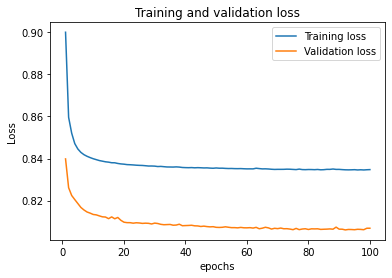

In [51]:
train_loss = train_history.history['loss']
val_loss= train_history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

# Plot Loss function
plt.figure()
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.plot(epochs, train_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

As can be seen, the loss function decreases until it converges at 0.8, because the model generates the maximum value of 1 and the data may be higher. We do not seek to reduce the value further because this solution is a simplification and the result obtained is already a good approximation.

We also observe that the loss of the validation set is usually less than that of the training, because the data is very similar.

# PREDICTIONS

In [52]:
to_predict = np.concatenate((validation_x, test_x))
test_y = np.concatenate(([0,] * validation_x.shape[0], [1,]*test_x.shape[0]))

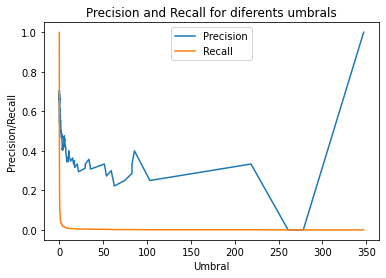

In [54]:
from sklearn.metrics import precision_recall_curve

# Calculate the error of the replica generated by the autoencoder
replications = autoencoder.predict(to_predict, decoded=True)
errors = np.mean(np.power(to_predict - replications,2), axis=1)

# Plot the precision recall curve
precision, recall, umbral = precision_recall_curve(test_y, errors)
plt.plot(umbral, precision[1:], label="Precision")
plt.plot(umbral, recall[1:], label="Recall")
plt.title('Precision and Recall for diferents umbrals')
plt.xlabel('Umbral')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

## Confusion Matrix

1    2084
0    1190
dtype: int64


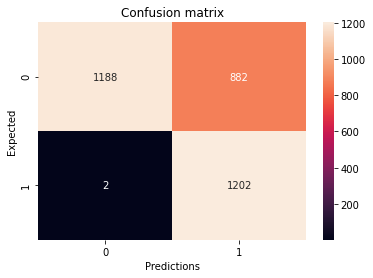

In [55]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

prediction = autoencoder.predict(to_predict, umbral=0.005)
print(pd.DataFrame(prediction).value_counts())
cm = confusion_matrix(test_y, prediction)

# View Confusion matrix
axes = plt.axes()
axes.set_title('Confusion matrix')
sns.heatmap(cm, annot=True,  fmt="d", ax=axes)
axes.set_xlabel('Predictions')
axes.set_ylabel('Expected')
plt.show()

# GRAPHIC REPRESENTATION

Now we are going to see an example of how the autoencoder is capable of making an approximate replica of companies that are not bankrupt. In addition to examples where the autoencoder is not able to replicate them, that is to say that the company is bankrupt.

In [59]:
def approximation(data, significative):
  for i in significative:
    plt.figure()
    plt.plot(data[i], label='real')
    plt.plot(autoencoder.predict(data[i].reshape(1,64), decoded=True).reshape(64,), label='predicction')
    plt.legend()
    plt.show()

## Approximation of companies that are not bankrupt 

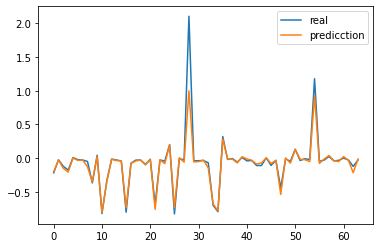

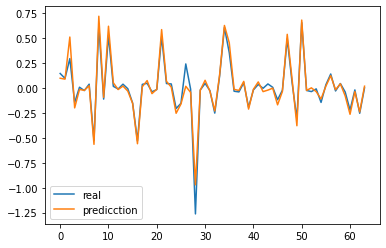

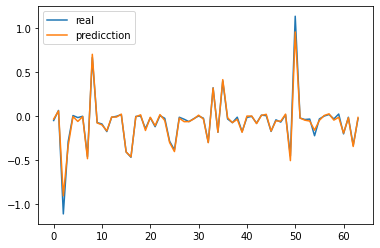

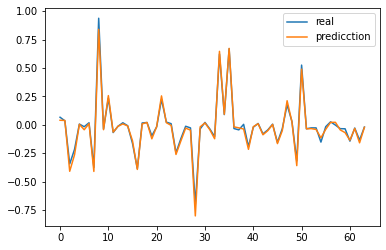

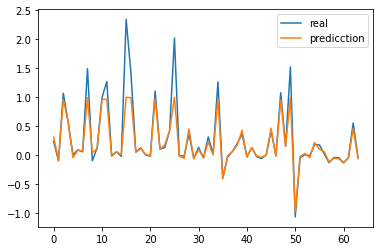

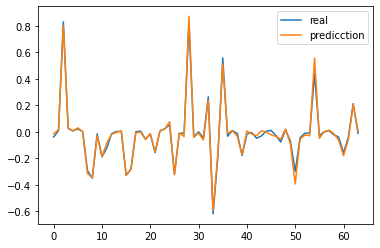

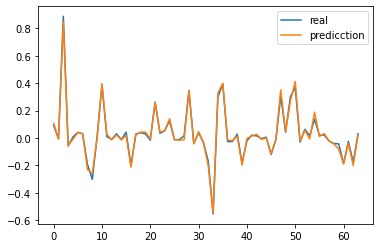

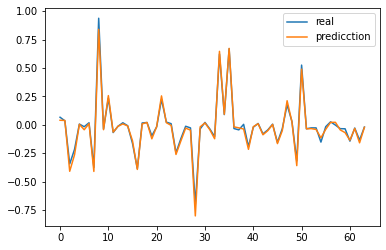

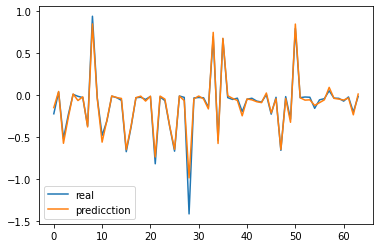

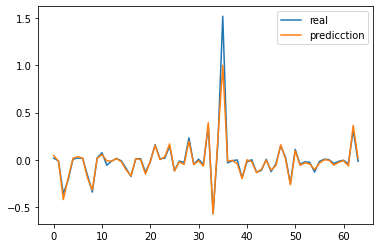

In [57]:
significative = [0, 1, 4, 10, 13, 16, 18, 20, 22, 28]
# Plot approximations
approximation(validation_x, significative)

## Approximation of companies that are bankrupt

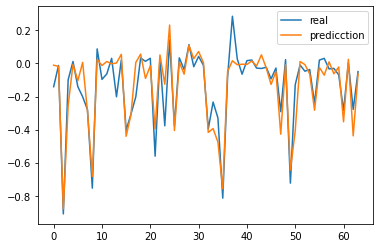

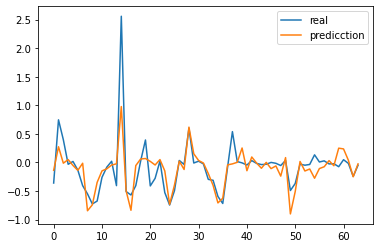

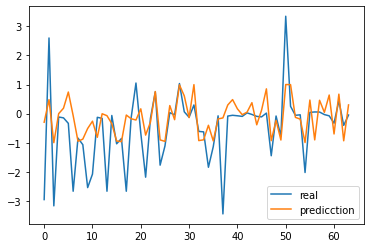

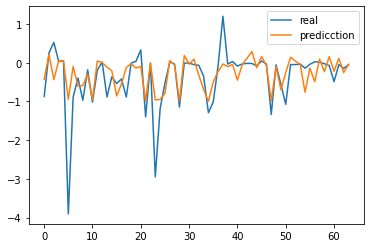

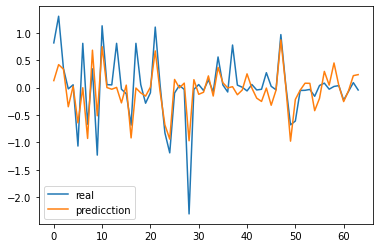

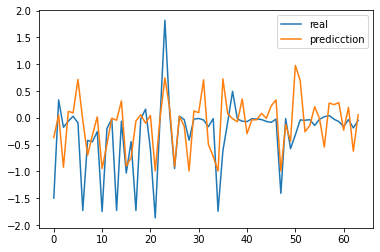

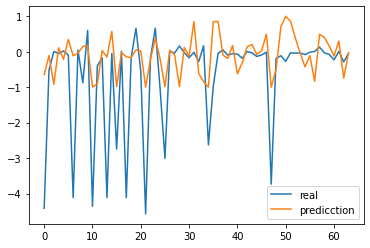

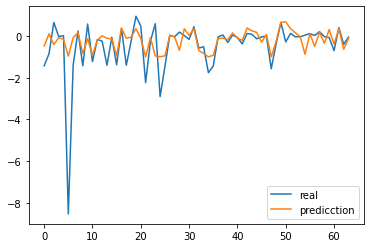

In [60]:
significative = [22, 27, 33, 40, 43, 45, 58, 69]
approximation(test_x, significative)